## Load Libraries

In [5]:
from PIL import Image
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
#import cv2 as cv
import re
import numpy as np
import torchvision.transforms as transforms
import torch 
import torch.nn.functional as F
from torch.utils.data import Dataset
import os
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision import models
import matplotlib.pyplot as plt
from nltk.tokenize import word_tokenize
from collections import defaultdict

In [6]:
captions = pd.read_csv("./Flickr_Data/captions.txt")
captions.head()

,image,caption
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...


In [7]:
captions.iloc[4,:]

image                              1000268201_693b08cb0e.jpg
caption    A little girl in a pink dress going into a woo...
Name: 4, dtype: object

In [8]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)
    return text

In [9]:
captions['caption'] = captions['caption'].apply(clean_text)
captions.head()

,image,caption
0,1000268201_693b08cb0e.jpg,a child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,a girl going into a wooden building
2,1000268201_693b08cb0e.jpg,a little girl climbing into a wooden playhouse
3,1000268201_693b08cb0e.jpg,a little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e.jpg,a little girl in a pink dress going into a woo...


In [10]:
# Tokenize sentences
token_words = []

for index,text in enumerate(captions['caption']):
    word_list = word_tokenize(text)
    token_words.append(word_list)

In [11]:
# Create a word dictionary

word_counts = defaultdict(int)

# Count word frequencies
for sent in token_words:
    for word in sent:
        word_counts[word] += 1

# Filter out dictionary elements where value is less than certain frequency

filtered_word_count = {word: count for word, count in word_counts.items() if count >= 3}

(array([6.7700e+02, 7.2360e+03, 1.7093e+04, 9.3120e+03, 4.7610e+03,
        9.4600e+02, 3.4700e+02, 5.4000e+01, 2.5000e+01, 4.0000e+00]),
 array([ 1. ,  4.5,  8. , 11.5, 15. , 18.5, 22. , 25.5, 29. , 32.5, 36. ]),
 <BarContainer object of 10 artists>)

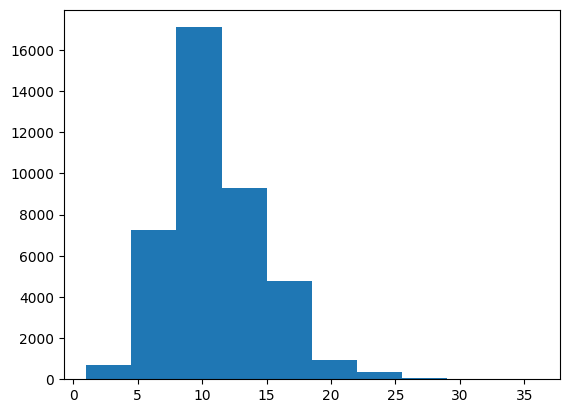

In [12]:
len_of_sentences = []
for i in token_words:
    len_of_sentences.append(len(i))
    
plt.hist(len_of_sentences)

In [13]:
# Let us tokenize it at 20 words
padded_text = []
for i in token_words:
    if len(i) > 15:
        sent = i[0:15]
        sent.append('<END>')
        
    else:
        sent = i + ['<END>'] + ['<PAD>'] * (15 - len(i))
    padded_text.append(sent)


In [14]:
padded_text[4]

['a',
 'little',
 'girl',
 'in',
 'a',
 'pink',
 'dress',
 'going',
 'into',
 'a',
 'wooden',
 'cabin',
 '<END>',
 '<PAD>',
 '<PAD>',
 '<PAD>']

(array([    0.,     0.,     0.,     0.,     0., 40455.,     0.,     0.,
            0.,     0.]),
 array([15.5, 15.6, 15.7, 15.8, 15.9, 16. , 16.1, 16.2, 16.3, 16.4, 16.5]),
 <BarContainer object of 10 artists>)

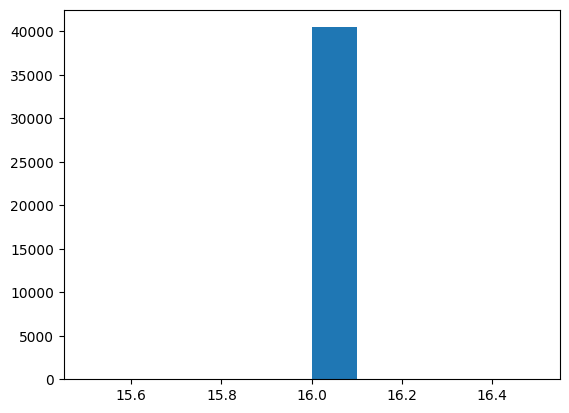

In [15]:
len_of_sentences = []
for i in padded_text:
    len_of_sentences.append(len(i))
    
plt.hist(len_of_sentences)

In [16]:
vocab = {
    "<PAD>": 0,
    "<UNK>": 1,
    "<END>":2
}

for token in filtered_word_count:
    vocab[token] = len(vocab)

In [17]:
token_to_idx = defaultdict(lambda: vocab["<UNK>"])
token_to_idx.update(vocab)

In [18]:
idx_to_token = {v: k for k, v in token_to_idx.items()}
idx_to_token

{0: '<PAD>',
 1: '<UNK>',
 2: '<END>',
 3: 'a',
 4: 'child',
 5: 'in',
 6: 'pink',
 7: 'dress',
 8: 'is',
 9: 'climbing',
 10: 'up',
 11: 'set',
 12: 'of',
 13: 'stairs',
 14: 'an',
 15: 'way',
 16: 'girl',
 17: 'going',
 18: 'into',
 19: 'wooden',
 20: 'building',
 21: 'little',
 22: 'playhouse',
 23: 'the',
 24: 'to',
 25: 'her',
 26: 'cabin',
 27: 'black',
 28: 'dog',
 29: 'and',
 30: 'spotted',
 31: 'are',
 32: 'fighting',
 33: 'tricolored',
 34: 'playing',
 35: 'with',
 36: 'each',
 37: 'other',
 38: 'on',
 39: 'road',
 40: 'white',
 41: 'brown',
 42: 'spots',
 43: 'staring',
 44: 'at',
 45: 'street',
 46: 'two',
 47: 'dogs',
 48: 'different',
 49: 'breeds',
 50: 'looking',
 51: 'pavement',
 52: 'moving',
 53: 'toward',
 54: 'covered',
 55: 'paint',
 56: 'sits',
 57: 'front',
 58: 'painted',
 59: 'rainbow',
 60: 'hands',
 61: 'bowl',
 62: 'sitting',
 63: 'large',
 64: 'small',
 65: 'grass',
 66: 'plays',
 67: 'fingerpaints',
 68: 'canvas',
 69: 'it',
 70: 'there',
 71: 'pigtails',

In [19]:
word_index_sentences = []
for ind,sent in enumerate(padded_text):
    if ind == 4:
        print(sent)
    wrd_index = [token_to_idx[token] for token in sent]
    word_index_sentences.append(wrd_index)

['a', 'little', 'girl', 'in', 'a', 'pink', 'dress', 'going', 'into', 'a', 'wooden', 'cabin', '<END>', '<PAD>', '<PAD>', '<PAD>']


In [20]:
word_index_sentences[4]

[3, 21, 16, 5, 3, 6, 7, 17, 18, 3, 19, 26, 2, 0, 0, 0]

In [21]:
word_index_sentences[4]

[3, 21, 16, 5, 3, 6, 7, 17, 18, 3, 19, 26, 2, 0, 0, 0]

In [22]:
class custom_dataset_class(Dataset):
    def __init__(self, data_path, caption_index ,captions, train = True, transform = None):
        self.data_paths = data_path
        self.data_list = list(captions['image'])
        #print(self.data_list)
        self.transform = transform
        self.word_index_sentences = caption_index
        
    def __len__(self):
        return(len(self.data_list))
    
    def return_original_image(self, idx):
        file_path = os.path.join(self.data_paths,self.data_list[idx])
        image = Image.open(file_path)
        return(image)
    
    def get_captions(self,index):
        #print("testing here")
        #print(index)
        #print([idx_to_token[i] for i in word_index_sentences[index]])
        
        return(self.word_index_sentences[index])
        
    def __getitem__(self,idx):
        file_path = os.path.join(self.data_paths,self.data_list[idx])
        #print(idx)
        #print(file_path)
        image = Image.open(file_path)
        #image_unf = self.uniform(image)
        if self.transform:
            image = self.transform(image)
        return image,torch.tensor(self.get_captions(index = idx))

Transformation required for restnet 50 model

In [23]:
tcomp = transforms.Compose([
    transforms.Resize(256),  
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],       
        std=[0.229, 0.224, 0.225])])

In [24]:
dpath = "./Flickr_Data/Images"

train_dataset = custom_dataset_class(data_path=dpath,captions = captions, caption_index=word_index_sentences, transform=tcomp)

In [25]:
word_index_sentences[4]

[3, 21, 16, 5, 3, 6, 7, 17, 18, 3, 19, 26, 2, 0, 0, 0]

In [26]:
len(os.listdir(dpath))

8091

In [27]:
[idx_to_token[i] for i in word_index_sentences[4]]

['a',
 'little',
 'girl',
 'in',
 'a',
 'pink',
 'dress',
 'going',
 'into',
 'a',
 'wooden',
 'cabin',
 '<END>',
 '<PAD>',
 '<PAD>',
 '<PAD>']

Text(0.5, 1.0, "['a', 'black', 'dog', 'running', 'in', 'the', 'surf', '<END>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>']")

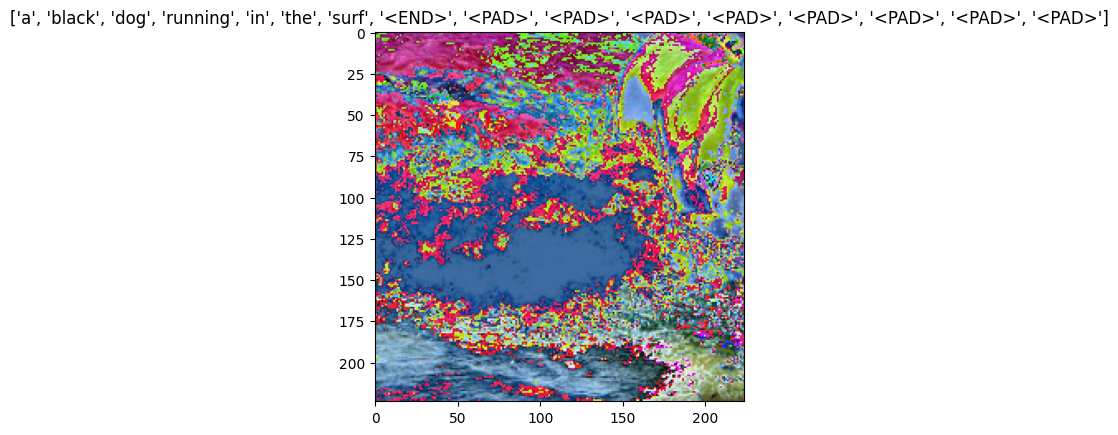

In [177]:
# Let us see a cat and dog to check if images are loaded correcly

img = train_dataset[90]
fig = plt.figure()
plt.imshow(transforms.functional.to_pil_image(img[0]))
title = [idx_to_token[i] for i in img[1].tolist()]
plt.title(title)

## Encoder Class

In [231]:
class Encoder_Restnet_CNN(nn.Module):
    def __init__(self, embedding_size):
        super().__init__()
        resnet = models.resnet50(pretrained=True)
        for param in resnet.parameters():
            param.requires_grad = False

        self.resnet = nn.Sequential(*list(resnet.children())[:-1])
        self.fc = nn.Linear(resnet.fc.in_features, embedding_size)
        self.bn = nn.LayerNorm(embedding_size) 
        self.relu =  nn.GELU()
        self.dropout = nn.Dropout(0.2)
        
    def forward(self, image):
        x = self.resnet(image)
        #print(x.shape)
        x = x.view(x.size(0), -1)
        #print(x.shape)
        x = self.fc(x)
        x = self.bn(x)
        x = self.relu(x)
        x = self.dropout(x)
        return(x)

In [232]:
encoder = Encoder_Restnet_CNN(embedding_size=50)

C:\Users\Ashutosh\torch311_env\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Ashutosh\torch311_env\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [233]:
enc_out = encoder(img[0].unsqueeze(0))

In [234]:
class decoder_lstm(nn.Module):
    def __init__(self, embedding_size, hidden_size,vocab_size,num_layers):
        super().__init__()
        self.embed = nn.Embedding(vocab_size, embedding_size)
        self.lstm = nn.LSTM(embedding_size, hidden_size, num_layers)
        self.linear = nn.Linear(hidden_size, vocab_size)
        self.dropout = nn.Dropout(0.2)
        
    def forward(self, image_feature, caption):
        #print("here")
        #print(caption.shape)
        x = self.embed(caption)
        #print("there")
        x = self.dropout(x)
        #print("somewhere")
        #print(image_feature.unsqueeze(1).shape)
        #print(x.shape)
        x = torch.cat((image_feature.unsqueeze(1),x),dim=1)
        #print("nowhere")
        hiddens, _ = self.lstm(x)
        outputs = self.linear(hiddens)
        return(outputs)
        
    

In [225]:
decoder = decoder_lstm(embedding_size=50,hidden_size=50,vocab_size=len(idx_to_token),num_layers = 1)

In [235]:
class encoder_to_decoder(nn.Module):
    def __init__(self,embedding_size=50,hidden_size=50,vocab_size=len(idx_to_token),num_layers = 5):
        super().__init__()
        self.encoder = Encoder_Restnet_CNN(embedding_size=50)
        self.decoder = decoder_lstm(embedding_size=embedding_size,
                                    hidden_size=hidden_size,
                                    vocab_size=vocab_size,
                                    num_layers = num_layers)
    def forward(self, image,caption):
        image_features = self.encoder(image)
        outputs = self.decoder(image_features,caption)
        return outputs
    
    def caption_image(self, image, idx_to_token, max_length = 20):
        generated_caption = []
        
        with torch.no_grad():
            x = self.encoder(image.unsqueeze(0))
            states = None
            x_sequence = []
            hidden_list = []
            linear_output_list = []
            for _ in range(max_length):
                hidden, states = self.decoder.lstm(x.unsqueeze(0), states)
                hidden_list.append(hidden)
                output = self.decoder.linear(hidden).detach()
                linear_output_list.append(output)
                predicted_word = idx_to_token[np.argmax(np.array(output))]
                
                generated_caption.append(predicted_word)
                x = self.decoder.embed(output.argmax()).unsqueeze(0)
                x_sequence.append(x)
                if predicted_word == "<END>":
                    break
        return(generated_caption,x_sequence,hidden_list,linear_output_list)
    
    
    def caption_image2(self, image, idx_to_token, max_length = 20):
        generated_caption = []
        x_sequence = []
        hidden_list = []
        linear_output_list = []
        with torch.no_grad():
            x = model.encoder(image.unsqueeze(0))
            #print(x)
            states = None
            for _ in range(20):
                hidden, states = model.decoder.lstm(x.unsqueeze(0), states)
                hidden_list.append(hidden)
                output = model.decoder.linear(hidden).detach()
                linear_output_list.append(output)
                probs = F.softmax(output.squeeze(0), dim=-1)           

                        #  Choose between greedy and random sampling
                greedy_prob = 0.7  # 70% chance to use argmax, 30% to sample
                if random.random() < greedy_prob:
                    predicted_idx = torch.argmax(probs, dim=-1).item()
                else:
                    predicted_idx = torch.multinomial(probs, num_samples=1).item()

                predicted_word = idx_to_token[predicted_idx]
                #predicted_word = idx_to_token[np.argmax(np.array(output))]
                print(predicted_word)

                generated_caption.append(predicted_word)
                x = model.decoder.embed(model.decoder.linear(hidden).argmax()).unsqueeze(0)
                x_sequence.append(x)
                #print("next x is ".format(x))
                if predicted_word == "<END>":
                    break
        return(generated_caption,x_sequence,hidden_list,linear_output_list)

In [227]:
etd = encoder_to_decoder()

In [236]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [237]:
e_to_d = encoder_to_decoder().to(device)

In [238]:
data_loader = DataLoader(
    train_dataset,
    batch_size=32,
    shuffle=True)

In [92]:
criterion = nn.CrossEntropyLoss(ignore_index= 0 )
optimizer = optim.Adam(e_to_d.parameters(), lr = 0.001)
num_epoch = 5

image = train_dataset[1193][0].unsqueeze(0)
caption = train_dataset[1193][1].unsqueeze(0)
caption

tensor([[ 46, 821,  29,   3,   4,  31,  62,  80,   3, 642,  12,   1,   5,  57,
          12,   2]])

In [64]:
caption[:,:-1]

tensor([[ 46, 821,  29,   3,   4,  31,  62,  80,   3, 642,  12,   1,   5,  57,
          12]])

In [110]:
outputs = e_to_d(image, caption[:,:-1])

RuntimeError: Input type (torch.FloatTensor) and weight type (torch.cuda.FloatTensor) should be the same or input should be a MKLDNN tensor and weight is a dense tensor

In [80]:
torch.argmax(outputs.reshape(-1,outputs.shape[2]), axis = 1)

tensor([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3])

In [193]:
for temp_image, temp_caption in data_loader:
    print(temp_image.shape)

torch.Size([32, 3, 224, 224])
torch.Size([32, 3, 224, 224])
torch.Size([32, 3, 224, 224])
torch.Size([32, 3, 224, 224])
torch.Size([32, 3, 224, 224])
torch.Size([32, 3, 224, 224])
torch.Size([32, 3, 224, 224])
torch.Size([32, 3, 224, 224])
torch.Size([32, 3, 224, 224])
torch.Size([32, 3, 224, 224])
torch.Size([32, 3, 224, 224])
torch.Size([32, 3, 224, 224])
torch.Size([32, 3, 224, 224])
torch.Size([32, 3, 224, 224])
torch.Size([32, 3, 224, 224])
torch.Size([32, 3, 224, 224])
torch.Size([32, 3, 224, 224])
torch.Size([32, 3, 224, 224])
torch.Size([32, 3, 224, 224])
torch.Size([32, 3, 224, 224])
torch.Size([32, 3, 224, 224])
torch.Size([32, 3, 224, 224])
torch.Size([32, 3, 224, 224])
torch.Size([32, 3, 224, 224])
torch.Size([32, 3, 224, 224])
torch.Size([32, 3, 224, 224])
torch.Size([32, 3, 224, 224])


KeyboardInterrupt: 

In [239]:
criterion = nn.CrossEntropyLoss(ignore_index= 0 )
optimizer = optim.Adam(e_to_d.parameters(), lr = 0.001)
num_epoch = 10

for epoch in range(num_epoch):
    running_loss = 0
    for temp_image, temp_caption in data_loader:
        temp_image = temp_image.to(device)
        temp_caption = temp_caption.to(device)
        
        outputs = e_to_d(temp_image, temp_caption[:,:-1])
        #outputs = torch.argmax(outputs.reshape(-1,outputs.shape[2]), axis = 1)
        loss = criterion(outputs.reshape(-1,outputs.shape[2]), temp_caption.reshape(-1))
        
        optimizer.zero_grad()
        loss.backward()
        
        optimizer.step()
        
        running_loss += loss.item()
        
    epoch_loss = running_loss / len(data_loader)

    print(f"Epoch [{epoch+1}/{num_epoch}] Loss: {epoch_loss:.4f}")
        

Epoch [1/10] Loss: 5.3612
Epoch [2/10] Loss: 5.2627
Epoch [3/10] Loss: 5.2597
Epoch [4/10] Loss: 5.2582
Epoch [5/10] Loss: 4.7282
Epoch [6/10] Loss: 4.2718
Epoch [7/10] Loss: 4.1111
Epoch [8/10] Loss: 4.0137
Epoch [9/10] Loss: 3.9419
Epoch [10/10] Loss: 3.8875


In [240]:
torch.save(e_to_d.state_dict(), "image_to_caption_model.pth")

In [ ]:
x = encoder(img[0].unsqueeze(0))

In [ ]:
x.unsqueeze(0).shape

In [ ]:
fot i in range(20):
    hidden, states = decoder.lstm(x.unsqueeze(0))

In [ ]:
hidden, states = decoder.lstm(x.unsqueeze(0))

In [ ]:
decoder.embed(decoder.linear(hidden).argmax()).unsqueeze(0).shape

In [ ]:
idx_to_token
np.where(np.array(decoder.linear(hidden).argmax(1)))

In [ ]:
decoder.linear(hidden).argmax(1)

In [ ]:
print(idx_to_token[np.argmax(np.array(decoder.linear(hidden).detach()))])

In [ ]:
idx_to_token[2]

In [ ]:
def caption_image(image, idx_to_token, max_length = 20):
    generated_caption = []
    x = encoder(image.unsqueeze(0))
    states = None
    hidden_list = []
    for _ in range(4):
        hidden, states = decoder.lstm(x.unsqueeze(0), states)
        output = decoder.linear(hidden)
        predicted_word = idx_to_token[np.argmax(np.array(decoder.linear(hidden).detach()))]
        generated_caption.append(predicted_word)
        #print(hidden.shape)
        print(decoder.linear(hidden).shape)
        x = decoder.embed(decoder.linear(hidden).argmax()).unsqueeze(0)
        #print(x)
        hidden_list.append(decoder.linear(hidden))
        if predicted_word == "<END>":
            break
    return(hidden_list)

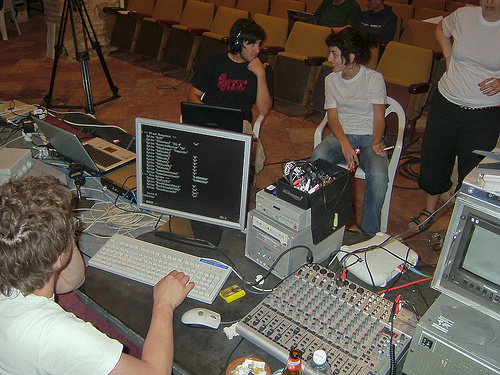

In [121]:
img = train_dataset.return_original_image(19000)
img

In [125]:
img = train_dataset[19000]
x = model.encoder(img[0].unsqueeze(0))
hidden, states = model.decoder.lstm(x.unsqueeze(0), None)

In [246]:
model = e_to_d.to("cpu")

In [258]:
generated_caption = []
import random
img = train_dataset[4433]
image = img[0]
print("actual caption")
print([idx_to_token[i] for i in np.array(img[1].tolist()).flatten()])
with torch.no_grad():
    x = model.encoder(image.unsqueeze(0))
    #print(x)
    states = None
    x_sequence = []
    hidden_list = []
    linear_output_list = []
    for _ in range(20):
        hidden, states = model.decoder.lstm(x.unsqueeze(0), states)
        #hidden_list.append(hidden)
        output = model.decoder.linear(hidden).detach()
        #linear_output_list.append(output)
        probs = F.softmax(output.squeeze(0), dim=-1)           
        
                # 🔁 Choose between greedy and random sampling
        greedy_prob = 1  # 70% chance to use argmax, 30% to sample
        if random.random() < greedy_prob:
            predicted_idx = torch.argmax(probs, dim=-1).item()
        else:
            predicted_idx = torch.multinomial(probs, num_samples=1).item()

        predicted_word = idx_to_token[predicted_idx]
        #predicted_word = idx_to_token[np.argmax(np.array(output))]
        #print(predicted_word)

        generated_caption.append(predicted_word)
        x = model.decoder.embed(model.decoder.linear(hidden).argmax()).unsqueeze(0)
        x_sequence.append(x)
        #print("next x is ".format(x))
        if predicted_word == "<END>":
            break
print(generated_caption)

actual caption
['a', 'person', 'lays', 'down', 'on', 'the', 'street', 'with', 'his', 'shoes', 'off', '<END>', '<PAD>', '<PAD>', '<PAD>', '<PAD>']
['a', 'man', 'in', 'a', 'woman', 'in', 'a', 'woman', 'in', 'a', 'woman', 'in', 'a', 'woman', 'in', 'a', 'woman', 'in', 'a', 'woman']


In [229]:
model = etd

In [196]:
train_dataset[19000][0].unsqueeze(0).shape

torch.Size([1, 3, 224, 224])

In [230]:
model.caption_image(train_dataset[19000][0], idx_to_token = idx_to_token)

C:\Users\Ashutosh\AppData\Local\Temp\ipykernel_18020\4055255309.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  predicted_word = idx_to_token[np.argmax(np.array(output))]


(['beer',
  'beer',
  'beer',
  'beer',
  'beer',
  'beer',
  'beer',
  'beer',
  'beer',
  'beer',
  'beer',
  'beer',
  'beer',
  'beer',
  'beer',
  'beer',
  'beer',
  'beer',
  'beer',
  'beer'],
 [tensor([[ 0.3937,  1.2244, -1.6326,  1.1818,  1.4133, -0.7526, -0.4975,  0.6376,
           -0.7073,  0.9614, -0.4111,  0.2824,  0.6313,  1.2353, -0.8664,  0.5462,
            0.8112, -2.8660,  0.1817, -0.9939,  0.9543,  0.5060, -0.4344, -0.7030,
           -1.2588,  0.8693,  2.5554, -0.1961, -0.1412,  2.5216, -0.6375, -1.0834,
            3.0957,  0.0555, -0.3968, -0.5279, -0.2676, -0.0301,  2.3756,  0.4021,
           -1.4537,  1.2292, -0.3713,  0.9219, -1.6303, -0.7843, -2.0630, -0.7553,
            0.4625,  1.1290]]),
  tensor([[ 0.3937,  1.2244, -1.6326,  1.1818,  1.4133, -0.7526, -0.4975,  0.6376,
           -0.7073,  0.9614, -0.4111,  0.2824,  0.6313,  1.2353, -0.8664,  0.5462,
            0.8112, -2.8660,  0.1817, -0.9939,  0.9543,  0.5060, -0.4344, -0.7030,
           -1.2588, 

['children', 'having', 'a', 'pillow', 'fight', '<END>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>']
curious
beer
beer
beer
beer
beer
beer
beer
beer
beer
beer
fields
beer
beer
beer
dollar
telescope
winds
beer
earrings
['curious', 'beer', 'beer', 'beer', 'beer', 'beer', 'beer', 'beer', 'beer', 'beer', 'beer', 'fields', 'beer', 'beer', 'beer', 'dollar', 'telescope', 'winds', 'beer', 'earrings']


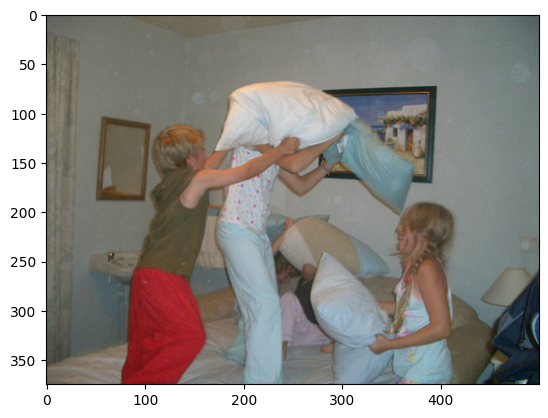

In [245]:
img = train_dataset.return_original_image(198)
print([idx_to_token[i] for i in train_dataset[198][1].tolist()])
fig = plt.figure()
plt.imshow(img) 
print(model.caption_image2(train_dataset[198][0], idx_to_token = idx_to_token)[0])

In [ ]:
img = train_dataset.return_original_image(500)
print([idx_to_token[i] for i in train_dataset[500][1].tolist()])
fig = plt.figure()
plt.imshow(img) 
print(e_to_d.caption_image(train_dataset[500][0], idx_to_token = idx_to_token))

In [ ]:
img = train_dataset.return_original_image(290)
print([idx_to_token[i] for i in train_dataset[290][1].tolist()])
fig = plt.figure()
plt.imshow(img) 
print(e_to_d.caption_image(train_dataset[290][0], idx_to_token = idx_to_token))

In [ ]:
torch.save(e_to_d.state_dict(), "image_to_caption_model.pth")

In [ ]:
output

In [ ]:
output = caption_image(train_dataset[90][0], idx_to_token = idx_to_token)

In [ ]:
image1 = train_dataset[9420][0]
image2 = train_dataset[10][0]

In [ ]:
x = encoder(image1.unsqueeze(0))
x

In [ ]:
y = encoder(image2.unsqueeze(0))
y

In [ ]:
hidden1, states = decoder.lstm(x.unsqueeze(0), None)
hidden1

In [ ]:
hidden2, states = decoder.lstm(y.unsqueeze(0), None)
hidden2

In [ ]:
output1 = decoder.linear(hidden1)
print(output1)
output2 = decoder.linear(hidden2)
print(output2)

In [ ]:
output = decoder.linear(hidden)
        predicted_word = idx_to_token[np.argmax(np.array(decoder.linear(hidden).detach()))]
        generated_caption.append(predicted_word)
        #print(hidden.shape)
        print(decoder.linear(hidden).shape)
        x = decoder.embed(decoder.linear(hidden).argmax()).unsqueeze(0)
        #print(x)
        hidden_list.append(decoder.linear(hidden))
        

In [ ]:
np.argmax(np.array(decoder.linear(hidden1).detach()))

In [ ]:
np.array(decoder.linear(hidden2).detach())

In [ ]:
outwords = []
hidden_list = []
x = encoder(image1.unsqueeze(0))
for i in range(15):
    image2 = train_dataset[i][0]
    
    hidden1, states = decoder.lstm(x.unsqueeze(0), None)
    output1 = decoder.linear(hidden1)
    outwords.append(np.argmax(np.array(output1.detach())))
    
    x = decoder.embed(decoder.linear(hidden1).argmax()).unsqueeze(0)
        #print(x)
    hidden_list.append(decoder.linear(hidden))
    print(x)
    if predicted_word == "<END>":
        break

In [ ]:
pd.Series(outwords).value_counts()

In [ ]:
np.argmax(np.array(decoder.linear(torch.rand(1,1,50)).detach()))

In [ ]:
hidden_vals = pd.DataFrame({"Col1": np.array(np.array(output[0].detach().numpy()).flatten()),
                           "Col2": np.array(output[1].detach().numpy()).flatten(),
                           "Col3": np.array(output[2].detach().numpy()).flatten(),
                           "Col4": np.array(output[3].detach().numpy()).flatten()})

In [ ]:
np.array(output.detach().numpy()).flatten()

In [ ]:
hidden_vals.to_csv("hidden_value.csv")

In [ ]:
weights = pd.DataFrame(decoder.linear.weight.detach().numpy())

In [ ]:
weights.to_csv("Linear_Weights.csv")

In [ ]:
idx_to_token[3970]

In [50]:
e_to_d.caption_image(train_dataset[500][0], idx_to_token = idx_to_token)[0]

C:\Users\Ashutosh\AppData\Local\Temp\ipykernel_18020\2490205478.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  predicted_word = idx_to_token[np.argmax(np.array(decoder.linear(hidden).detach()))]


['leggings',
 'fill',
 'fill',
 'fill',
 'fill',
 'fill',
 'fill',
 'fill',
 'fill',
 'fill',
 'fill',
 'fill',
 'fill',
 'fill',
 'fill',
 'fill',
 'fill',
 'fill',
 'fill',
 'fill']

In [53]:
e_to_d.caption_image(train_dataset[13674][0], idx_to_token = idx_to_token)[3]

C:\Users\Ashutosh\AppData\Local\Temp\ipykernel_18020\2490205478.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  predicted_word = idx_to_token[np.argmax(np.array(decoder.linear(hidden).detach()))]


[tensor([[[-9.0172,  2.9240,  5.0088,  ..., -4.4750, -4.7604, -4.7401]]]),
 tensor([[[-9.5449,  3.0595,  5.0082,  ..., -4.3942, -5.0589, -4.5119]]]),
 tensor([[[-9.5584,  3.0611,  5.0168,  ..., -4.3481, -5.0385, -4.4542]]]),
 tensor([[[-9.5913,  3.0720,  5.0346,  ..., -4.3623, -5.0533, -4.4657]]]),
 tensor([[[-9.5968,  3.0736,  5.0374,  ..., -4.3645, -5.0558, -4.4677]]]),
 tensor([[[-9.5978,  3.0738,  5.0379,  ..., -4.3649, -5.0562, -4.4680]]]),
 tensor([[[-9.5980,  3.0739,  5.0380,  ..., -4.3650, -5.0563, -4.4681]]]),
 tensor([[[-9.5981,  3.0739,  5.0381,  ..., -4.3650, -5.0563, -4.4681]]]),
 tensor([[[-9.5981,  3.0739,  5.0381,  ..., -4.3650, -5.0563, -4.4681]]]),
 tensor([[[-9.5981,  3.0739,  5.0381,  ..., -4.3650, -5.0563, -4.4681]]]),
 tensor([[[-9.5981,  3.0739,  5.0381,  ..., -4.3650, -5.0563, -4.4681]]]),
 tensor([[[-9.5981,  3.0739,  5.0381,  ..., -4.3650, -5.0563, -4.4681]]]),
 tensor([[[-9.5981,  3.0739,  5.0381,  ..., -4.3650, -5.0563, -4.4681]]]),
 tensor([[[-9.5981,  3.07

In [84]:
torch.argmax(torch.tensor([[1,2,3],[5,2,1]]), axis = 1)

tensor([2, 0])